<h1>Feature Engineering Techniques on Titanic's Survival Dataset</h1>

In [255]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import re # Regular Expression 

In [300]:
# Importing Dataset
df_train = pd.read_csv('../Datasets/Titanic_Survival/train.csv')
df_test = pd.read_csv('../Datasets/Titanic_Survival/test.csv')
df_gender = pd.read_csv('../Datasets/Titanic_Survival/gender_submission.csv')

# Concatenating Train and Test Set
data = pd.concat([df_train, df_test])

In [301]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


<h2>Getting Information on Dataset</h2>
The dataset is composed of 6 numerical features and 5 categorical ones, with a total of 1309 registers.<br>
<b>Null Entries: </b> 
- "Cabin" seems to indicate that a passenger with no Cabin is represented with a null entry, hence the significative number of null entries (1014). This is NOT a case of missing data!
- "Age", "Fare" and "Embarked" seems to have a small number of null entries, which could possibly be from missing data.
- "Survived" is intentionally left with NULL entries so as to identify train and test set


In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


<h2> Handling Missing Values </h2>

<h4>Cabin</h4>
We will create a flag boolean variable <b>Has_Cabin</b> to indicate whether the passenger has a cabin or not. Since this variable gives all the information we need on cabins, we will drop the original Cabin variable.

In [303]:
# Creating Has_Cabin flag variable to indicate whether or not a 
# passenger has a cabin instead of using null entries
data['Has_Cabin'] = ~data.Cabin.isnull() # is null returns True if it is null, so use tilde to convert
data.drop(['Cabin'], # which columns to drop
          axis = 1, # Dropping column-wise
          inplace = True) # Making modifications in the original dataframe

data.tail()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Has_Cabin
413,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,False
414,39.0,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,True
415,38.5,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,False
416,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,False
417,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,False


<h4>Age, Fare</h4>
We can treat missing values on numerical features by: 
- Dropping missing-values rows,
- Filling missing value with a column statistic (median, mean or mode)
- Training a predictive model to come up with the most suitable value

We will fill missing value with the column's median, since this metric is less influenced by outliers (which we haven't analysed yet)

In [304]:
# Treating Missing Values
data['Age'] = data.Age.fillna(data.Age.median()) 
data['Fare'] = data.Fare.fillna(data.Fare.median())

<h4>Embarked</h4>
As for missing values on categorical features, we can check which category occurs the most (a sort of mode) and replace missing values with it.

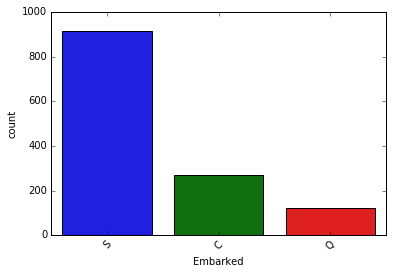

In [305]:
# Checking most common category and replacing missing values with it
sns.countplot(x='Embarked', data=data);
plt.xticks(rotation=45);

data['Embarked'] = data['Embarked'].fillna('S')

In [306]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1309 non-null float64
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Has_Cabin      1309 non-null bool
dtypes: bool(1), float64(3), int64(4), object(4)
memory usage: 124.0+ KB


<h3>Reducing noisy information</h3>
Feature <b>Name</b> seems to contain a passenger' social status. However, its name is meaningless when it comes to survival. Therefore, we need to extract the social status from "Name" and drop the original feature.

413              Spector, Mr. Woolf
414    Oliva y Ocana, Dona. Fermina
415    Saether, Mr. Simon Sivertsen
416             Ware, Mr. Frederick
417        Peter, Master. Michael J
Name: Name, dtype: object


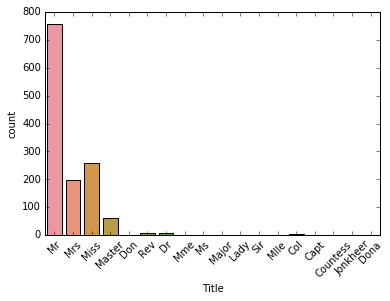

In [307]:
# Extracting Social Status from Name using regular expression
%matplotlib inline
print data.Name.tail()

# Getting All substrings that starts with a letter and ends with a dot .
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1)) 

data.drop(['Name'], axis = 1, inplace = True)

sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

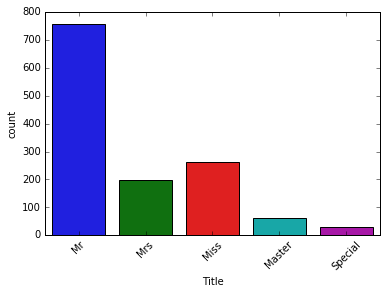

In [308]:
# Regrouping less numerous titles into more numerous ones by translating them
data['Title'] = data['Title'].replace({'Mlle':'Miss', 
                                       'Mme':'Mrs', 
                                       'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

In [309]:
data.tail()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Has_Cabin,Title
413,28.0,S,8.0500,0,1305,3,male,0,NaN,A.5. 3236,False,Mr
414,39.0,C,108.9000,0,1306,1,female,0,NaN,PC 17758,True,Special
415,38.5,S,7.2500,0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,False,Mr
416,28.0,S,8.0500,0,1308,3,male,0,NaN,359309,False,Mr
417,28.0,C,22.3583,1,1309,3,male,1,NaN,2668,False,Master


<h3>Dropping Other Unnecessary Features</h3>
Some features may contain identification information that has no 
correlation with target variable, such as <b>PassengerId</b> and <b>Ticket</b>. So, 
these features can be removed.

In [310]:
# Dropping Unnecessary Columns 
data.drop(['PassengerId', 'Ticket'], 
          axis=1, # Making Drop Column Wise
          inplace=True)  # Apply changes to the same dataframe instead of assigning to another one
data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Has_Cabin,Title
0,22,S,7.2500,0,3,male,1,0,False,Mr
1,38,C,71.2833,0,1,female,1,1,True,Mrs
2,26,S,7.9250,0,3,female,0,1,False,Miss
3,35,S,53.1000,0,1,female,1,1,True,Mrs
4,35,S,8.0500,0,3,male,0,0,False,Mr


<h2>Checking for Outliers</h2>

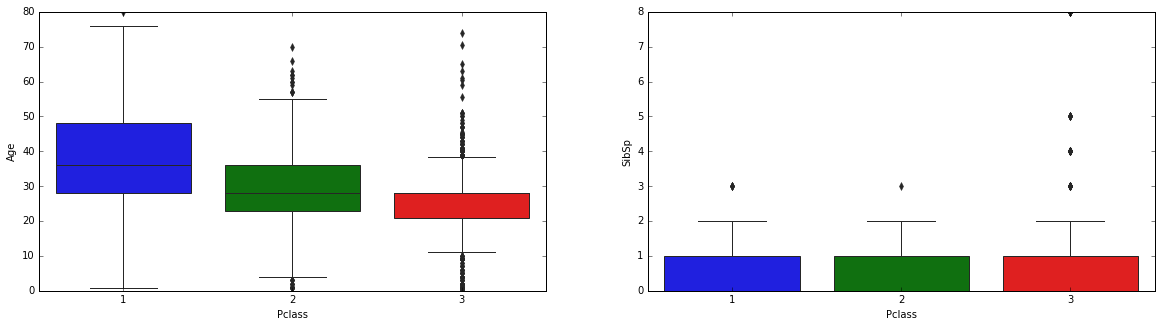

In [311]:
# Checking for Outliers
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize = (20, 5))

sns.boxplot(x = data.Pclass, y = data.Age, ax = ax1)
sns.boxplot(x = data.Pclass, y = data.SibSp, ax = ax2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 0 to 417
Data columns (total 10 columns):
Age          1141 non-null float64
Embarked     1141 non-null object
Fare         1141 non-null float64
Parch        1141 non-null int64
Pclass       1141 non-null int64
Sex          1141 non-null object
SibSp        1141 non-null int64
Survived     763 non-null float64
Has_Cabin    1141 non-null bool
Title        1141 non-null object
dtypes: bool(1), float64(3), int64(3), object(3)
memory usage: 90.3+ KB


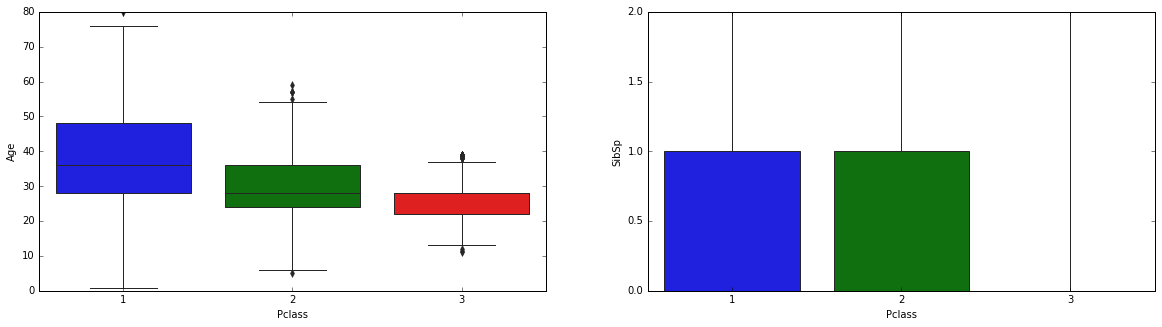

In [312]:
# Removing Outliers
data = data[~np.logical_and(data.Age >= 60, data.Pclass == 2)]
data = data[~np.logical_and(data.Age <= 4, data.Pclass == 2)]
data = data[~np.logical_and(data.Age >= 40, data.Pclass == 3)]
data = data[~np.logical_and(data.Age <= 10, data.Pclass == 3)]
data = data[data.SibSp <= 2]

data.info()

%matplotlib inline


fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize = (20, 5))

sns.boxplot(x = data.Pclass, y = data.Age, ax = ax1)
sns.boxplot(x = data.Pclass, y = data.SibSp, ax = ax2)

In [313]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 0 to 417
Data columns (total 10 columns):
Age          1141 non-null float64
Embarked     1141 non-null object
Fare         1141 non-null float64
Parch        1141 non-null int64
Pclass       1141 non-null int64
Sex          1141 non-null object
SibSp        1141 non-null int64
Survived     763 non-null float64
Has_Cabin    1141 non-null bool
Title        1141 non-null object
dtypes: bool(1), float64(3), int64(3), object(3)
memory usage: 90.3+ KB


<h3>Bin Numerical Data</h3>
One can also reduce the number of different values of a numerical data by making bins of data ranges. 
For example, we could regroup different <b>Age</b>s into 4 bins. The same can be done with <b>Fare</b> 

In [314]:
# Bin Numerical Data
# Binning numerical columns
data['CatAge'] = pd.qcut(data.Age, # Data Series
                         q=4, # Number of Quantiles
                         labels=False ) # Encode de Bins as Numbers
data['CatFare']= pd.qcut(data.Fare, q=4, labels=False)

# Dropping Unnecessary Columns 
data.drop(['Age', 'Fare'], axis=1, inplace= True)

data.head()

,Embarked,Parch,Pclass,Sex,SibSp,Survived,Has_Cabin,Title,CatAge,CatFare
0,S,0,3,male,1,0,False,Mr,0,0
1,C,0,1,female,1,1,True,Mrs,3,3
2,S,0,3,female,0,1,False,Miss,1,1
3,S,0,1,female,1,1,True,Mrs,3,3
4,S,0,3,male,0,0,False,Mr,3,1


<h2>Transforming Categorical Features into Numerical</h2>
Mathmatical models don't work with explicit categorial values. These values need to be translated to numerical data, which can be done by techniques such as
- Binarization
- One Hot Encoding
- Word2Vec 
<br>
We will apply the one-hot-encoding to transform categorical values into numerical

In [317]:
#Transform into binary variables
data_dum = pd.get_dummies(data)
data_dum.tail()

,Parch,Pclass,SibSp,Survived,Has_Cabin,CatAge,CatFare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special
413,0,3,0,NaN,False,1,1,0,0,1,0,1,0,0,1,0,0
414,0,1,0,NaN,True,3,3,1,0,0,1,0,0,0,0,0,1
415,0,3,0,NaN,False,3,0,0,0,1,0,1,0,0,1,0,0
416,0,3,0,NaN,False,1,1,0,0,1,0,1,0,0,1,0,0
417,1,3,1,NaN,False,1,2,1,0,0,0,1,1,0,0,0,0


<h2>Scaling Features</h2>

In [345]:
# Scaling Features
df_train = data_dum[~data_dum.Survived.isnull()]
df_test = data_dum[data_dum.Survived.isnull()]

#df_train_target = df_train.Survived
#df_train = df_train.drop(['Survived'], axis = 1)
df_test = df_test.drop(['Survived'], axis = 1)

min_max_scaler_train = preprocessing.MinMaxScaler()
min_max_scaler_test = preprocessing.MinMaxScaler()

df_train_scaled = pd.DataFrame(min_max_scaler_train.fit_transform(df_train))
df_test_scaled = pd.DataFrame(min_max_scaler_test.fit_transform(df_test))

df_train_scaled.columns = df_train.columns
df_test_scaled.columns = df_test.columns

In [348]:
df_train_scaled.head()

,Parch,Pclass,SibSp,Survived,Has_Cabin,CatAge,CatFare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,0,1,0.5,0,0,0.000000,0.000000,0,0,1,0,1,0,0,1,0,0
1,0,0,0.5,1,1,1.000000,1.000000,1,0,0,1,0,0,0,0,1,0
2,0,1,0.0,1,0,0.333333,0.333333,0,0,1,1,0,0,1,0,0,0
3,0,0,0.5,1,1,1.000000,1.000000,0,0,1,1,0,0,0,0,1,0
4,0,1,0.0,0,0,1.000000,0.333333,0,0,1,0,1,0,0,1,0,0


<h2>Data Correlation</h2>

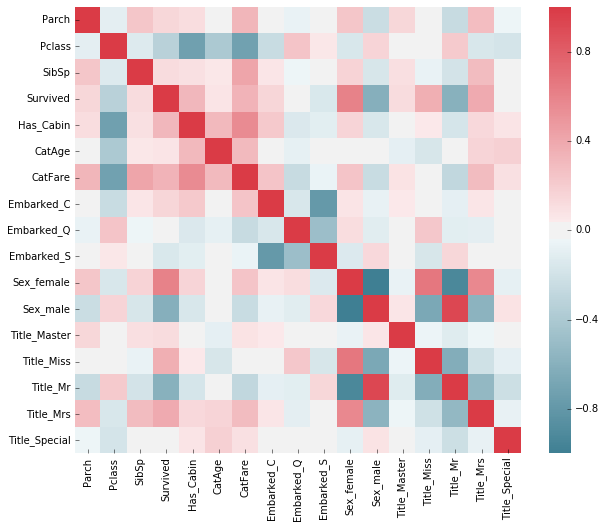

In [349]:
f, ax = plt.subplots(figsize=(10, 8))
data_corr = df_train_scaled.corr('pearson')
sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<h2>Principal Component Analysis</h2>

In [411]:
from sklearn.decomposition import PCA
df_train_normalized_target = df_train_scaled.Survived
df_train_normalized = df_train_scaled.drop(['Survived'], axis = 1)
df_test_normalized = df_test_scaled

pca_number_components = 6

pca = PCA(n_components = pca_number_components)
pca.fit(df_train_normalized)
data_train_transformed = pca.transform(df_train_normalized)
data_test_transformed = pca.transform(df_test_normalized)

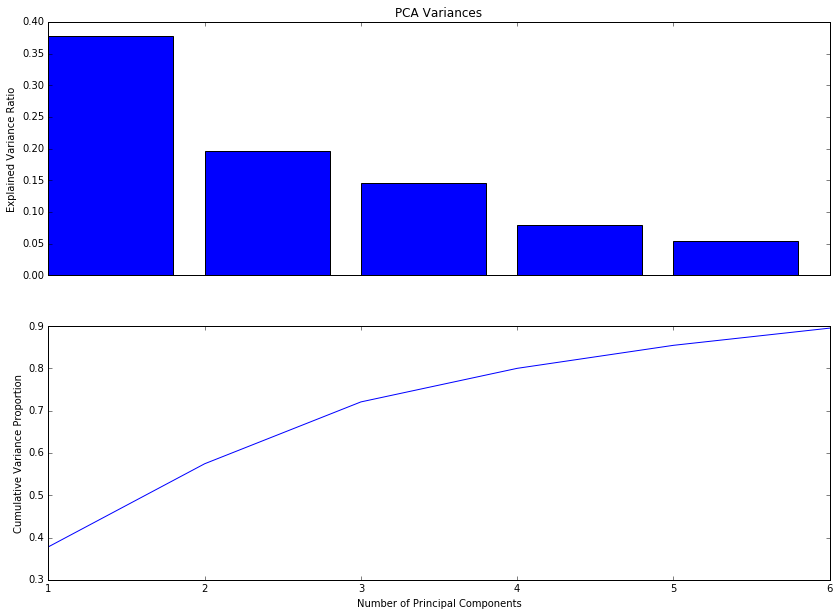

In [413]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows = 2, figsize = (14, 10), sharex = True)
x = np.arange(1, pca_number_components+1, 1)
y = pca.explained_variance_ratio_
y_cumsum = np.cumsum(y)

ax1.bar(x, y)
ax1.set_xlim(1, pca_number_components)
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA Variances')

ax2.plot(x, y_cumsum)
ax2.set_ylabel('Cumulative Variance Proportion')
ax2.set_xlabel('Number of Principal Components')


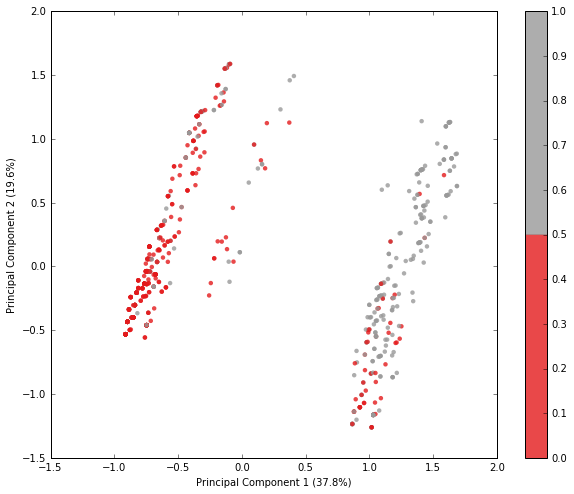

In [427]:
fig, ax = plt.subplots(figsize = (10, 8))
#ax.bar(data=pca.explained_variance_ratio_, )
plt.scatter(data_train_transformed[:, 0], 
            data_train_transformed[:, 1],
            c=df_train_normalized_target, 
            edgecolor='none', 
            alpha=0.8,
            cmap=plt.cm.get_cmap('Set1', 2))


plt.xlabel('Principal Component 1 (' + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%)')
plt.ylabel('Principal Component 2 (' + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%)')
plt.colorbar();